# The model tries to predict whether the user will churn in the future 2 months (month 3,4 ), given the feature generated from month 0,1,2

In [64]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from dateutil.relativedelta import relativedelta
import seaborn as sns
from wishpy.dataworker import DataWorker
dw = DataWorker(google_secret='../../../wishpy/client_secret.json')
import math

# # from scipy import stats
# from scipy.stats import chi2, chi2_contingency
# import statsmodels.stats.api as sms

# import ttd_experiment as ttd
%matplotlib inline

from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.metrics import mean_squared_error, r2_score
# import itertools
# import random
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder 

from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, roc_curve, roc_auc_score

from imblearn.over_sampling import SMOTE
from collections import Counter

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/wishpy/dataworker.py:83: UserWarning: [Errno 2] No such file or directory: '../../../wishpy/client_secret.json'
  warnings.warn(str(e))


In [65]:
df_raw = dw.td_query('''
select age
       ,gender
       ,waiting_day_1st_txn_bucket
       ,COAlESCE(user_first_txn_refund_category,'no refund') as user_first_txn_refund_category
       ,order_cnt
       ,min_shipping_time_shown_avg
       ,max_shipping_time_shown_avg
       ,mix_ttd_avg
       ,gmv
       ,gmv_avg
       ,user_ltv_segment
       ,previous_m_is_churned
       ,late_days_avg
       ,late_order_p
       ,refund_order_p
       ,lr_order_p
       ,we_order_p
       
       ,m_is_churned
from analytics.jay_churn_model_training_base
where country_code = 'US'
'''
,job_id=790048160 ##x_minus_1=2## 
                    
,engine='presto'
                )

You can look at job id 790048160


In [66]:
df = df_raw.copy()
df.head()

,age,gender,waiting_day_1st_txn_bucket,user_first_txn_refund_category,order_cnt,min_shipping_time_shown_avg,max_shipping_time_shown_avg,mix_ttd_avg,gmv,gmv_avg,user_ltv_segment,previous_m_is_churned,late_days_avg,late_order_p,refund_order_p,lr_order_p,we_order_p,m_is_churned
0,NaN,1,0.0,no refund,3,16.3,28.3,12.0,25.0,8.33,ltv_med,1,0.0,0.0,0.0,0.0,0.0,1
1,NaN,2,34.4,no refund,1,7.0,10.0,7.0,9.0,9.00,ltv_low,1,0.0,0.0,0.0,0.0,0.0,1
2,NaN,1,33.0,no refund,11,13.0,17.9,13.7,213.3,19.39,ltv_high,0,1.0,9.1,0.0,0.0,0.0,0
3,NaN,1,0.0,no refund,2,13.0,28.0,NaN,4.0,2.00,ltv_low,1,0.0,0.0,0.0,0.0,0.0,1
4,NaN,2,198.8,no refund,2,17.5,30.0,15.5,44.0,22.00,ltv_med,1,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
# df.info()

In [68]:
# label encoding the feature
le = LabelEncoder()
df['user_first_txn_refund_cat'] = le.fit_transform(df['user_first_txn_refund_category'])
df['user_ltv_segment_cat'] = le.fit_transform(df['user_ltv_segment'])

# creating instance of one-hot-encoder
# enc = OneHotEncoder(handle_unknown='ignore')
# enc_df = pd.DataFrame(enc.fit_transform(bridge_df[['Bridge_Types_Cat']]).toarray())
# # merge with main df bridge_df on key values
# df = df.join(enc_df)

# df['ttd_bucket'] = df['mix_ttd_avg'].apply(lambda x: ttd_bucket(x))

df_encoding = pd.get_dummies(df[['gender','user_first_txn_refund_category','user_ltv_segment']], prefix_sep='_',columns=['gender','user_first_txn_refund_category','user_ltv_segment'] , 
                             drop_first=False)
df_encoding.head()

df2 = pd.concat([df, df_encoding], axis=1)
df2.head()

,age,gender,waiting_day_1st_txn_bucket,user_first_txn_refund_category,order_cnt,min_shipping_time_shown_avg,max_shipping_time_shown_avg,mix_ttd_avg,gmv,gmv_avg,...,user_ltv_segment_cat,gender_0,gender_1,gender_2,user_first_txn_refund_category_logistics refund,user_first_txn_refund_category_no refund,user_first_txn_refund_category_other refund,user_ltv_segment_ltv_high,user_ltv_segment_ltv_low,user_ltv_segment_ltv_med
0,NaN,1,0.0,no refund,3,16.3,28.3,12.0,25.0,8.33,...,2,0,1,0,0,1,0,0,0,1
1,NaN,2,34.4,no refund,1,7.0,10.0,7.0,9.0,9.00,...,1,0,0,1,0,1,0,0,1,0
2,NaN,1,33.0,no refund,11,13.0,17.9,13.7,213.3,19.39,...,0,0,1,0,0,1,0,1,0,0
3,NaN,1,0.0,no refund,2,13.0,28.0,NaN,4.0,2.00,...,1,0,1,0,0,1,0,0,1,0
4,NaN,2,198.8,no refund,2,17.5,30.0,15.5,44.0,22.00,...,2,0,0,1,0,1,0,0,0,1


In [69]:
df2 = pd.concat([df, df_encoding], axis=1)
df2.head()

,age,gender,waiting_day_1st_txn_bucket,user_first_txn_refund_category,order_cnt,min_shipping_time_shown_avg,max_shipping_time_shown_avg,mix_ttd_avg,gmv,gmv_avg,...,user_ltv_segment_cat,gender_0,gender_1,gender_2,user_first_txn_refund_category_logistics refund,user_first_txn_refund_category_no refund,user_first_txn_refund_category_other refund,user_ltv_segment_ltv_high,user_ltv_segment_ltv_low,user_ltv_segment_ltv_med
0,NaN,1,0.0,no refund,3,16.3,28.3,12.0,25.0,8.33,...,2,0,1,0,0,1,0,0,0,1
1,NaN,2,34.4,no refund,1,7.0,10.0,7.0,9.0,9.00,...,1,0,0,1,0,1,0,0,1,0
2,NaN,1,33.0,no refund,11,13.0,17.9,13.7,213.3,19.39,...,0,0,1,0,0,1,0,1,0,0
3,NaN,1,0.0,no refund,2,13.0,28.0,NaN,4.0,2.00,...,1,0,1,0,0,1,0,0,1,0
4,NaN,2,198.8,no refund,2,17.5,30.0,15.5,44.0,22.00,...,2,0,0,1,0,1,0,0,0,1


In [70]:
features = df2.columns.values
a = list()
for f in features:
    a.append(100.0*sum(df2[f].isnull())/df2.shape[0])
df_missing = pd.DataFrame(a,index=features,columns=['missing_value_perc'])
df_missing

,missing_value_perc
age,95.956473
gender,0.000000
waiting_day_1st_txn_bucket,0.000000
user_first_txn_refund_category,0.000000
order_cnt,0.000000
min_shipping_time_shown_avg,0.004500
max_shipping_time_shown_avg,0.004500
mix_ttd_avg,35.066185
gmv,0.000000
gmv_avg,0.000000


Text(0.5,1,'avg churn rate is 82.05620708971684%')

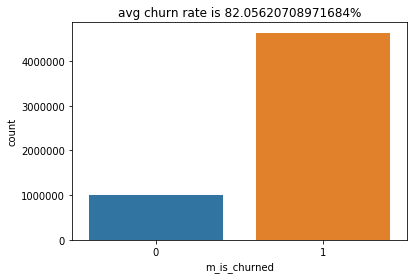

In [71]:
sns.countplot(x='m_is_churned', data=df2)
plt.title('avg churn rate is {}%'.format(100.0*df2.m_is_churned.sum()/len(df2.m_is_churned)))

Text(0.5,1,'avg churn rate is 89.62790805028875%')

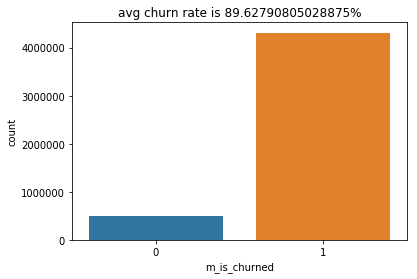

In [72]:
mask = df2.previous_m_is_churned== 1

sns.countplot(x='m_is_churned', data=df2[mask])
plt.title('avg churn rate is {}%'.format(100.0*df2[mask].m_is_churned.sum()/len(df2[mask].m_is_churned)))

Text(0.5,1,'avg churn rate is 38.474768377499494%')

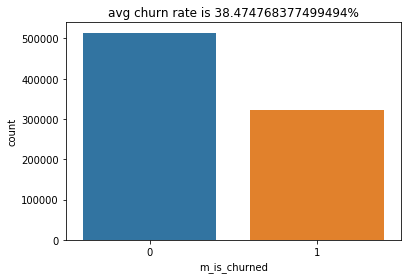

In [73]:
mask = df2.previous_m_is_churned== 0

sns.countplot(x='m_is_churned', data=df2[mask])
plt.title('avg churn rate is {}%'.format(100.0*df2[mask].m_is_churned.sum()/len(df2[mask].m_is_churned)))

Text(0.5,1,'avg churn rate is 92.16047651886599%')

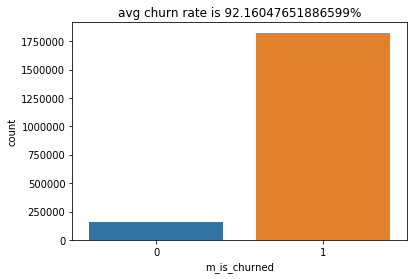

In [11]:
sns.countplot(x='m_is_churned', data=df2[df2.mix_ttd_avg.isnull()])
plt.title('avg churn rate is {}%'.format(100.0*df2[df2.mix_ttd_avg.isnull()].m_is_churned.sum()/len(df2[df2.mix_ttd_avg.isnull()].m_is_churned)))

Text(0.5,1,'avg churn rate is 76.5996020485252%')

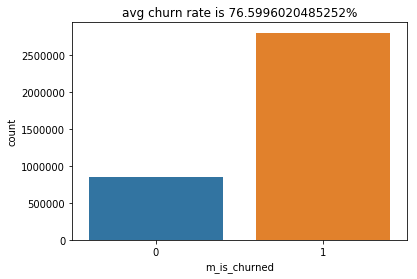

In [12]:
sns.countplot(x='m_is_churned', data=df2[df2.mix_ttd_avg.notnull()])
plt.title('avg churn rate is {}%'.format(100.0*df2[df2.mix_ttd_avg.notnull()].m_is_churned.sum()/len(df2[df2.mix_ttd_avg.notnull()].m_is_churned)))

In [74]:
def max_shown_bucket(x):
    if x<10:
        bucket = '10-'
    elif x<=20 :
        bucket = '10-20'
    elif x<=25 :
        bucket = '20-25'
    elif x<=30 :
        bucket = '25-30'
    elif x<=35 :
        bucket = '30-35'
    elif x<=40 :
        bucket = '35-40'
    elif x<=50 :
        bucket = '40-50'
    elif x>50 :
        bucket = '50+'
    return bucket

In [75]:
def we_bucket(x):
    if x<=0:
        bucket = '0-'
    elif x<=2 :
        bucket = '0-2'
    elif x<=5 :
        bucket = '2-5'
    elif x<=10 :
        bucket = '5-10'
    elif x<=20 :
        bucket = '10-20'
    elif x<=40 :
        bucket = '20-40'
    elif x<=90 :
        bucket = '40-90'
    elif x>90 :
        bucket = '90+'
    return bucket

In [76]:
df4 = df2.dropna(subset=['min_shipping_time_shown_avg', 'max_shipping_time_shown_avg'], inplace=False)
df4['we_bucket'] = df4['we_order_p'].apply(lambda x: we_bucket(x))
df4['max_shown_bucket'] = df4['max_shipping_time_shown_avg'].apply(lambda x: max_shown_bucket(x))
df4.shape

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(5644372, 31)

In [77]:
df_group = df4[['we_bucket','max_shown_bucket','mix_ttd_avg']].groupby(['we_bucket','max_shown_bucket'],as_index=False)['mix_ttd_avg'].mean()
df_group.columns = ['we_bucket','max_shown_bucket','bucket_ttd_avg']
df5 = df4.merge(df_group,how='left',on=['we_bucket','max_shown_bucket'])
df5.head()

,age,gender,waiting_day_1st_txn_bucket,user_first_txn_refund_category,order_cnt,min_shipping_time_shown_avg,max_shipping_time_shown_avg,mix_ttd_avg,gmv,gmv_avg,...,gender_2,user_first_txn_refund_category_logistics refund,user_first_txn_refund_category_no refund,user_first_txn_refund_category_other refund,user_ltv_segment_ltv_high,user_ltv_segment_ltv_low,user_ltv_segment_ltv_med,we_bucket,max_shown_bucket,bucket_ttd_avg
0,NaN,1,0.0,no refund,3,16.3,28.3,12.0,25.0,8.33,...,0,0,1,0,0,0,1,0-,25-30,17.197505
1,NaN,2,34.4,no refund,1,7.0,10.0,7.0,9.0,9.00,...,1,0,1,0,0,1,0,0-,10-20,13.557254
2,NaN,1,33.0,no refund,11,13.0,17.9,13.7,213.3,19.39,...,0,0,1,0,1,0,0,0-,10-20,13.557254
3,NaN,1,0.0,no refund,2,13.0,28.0,NaN,4.0,2.00,...,0,0,1,0,0,1,0,0-,25-30,17.197505
4,NaN,2,198.8,no refund,2,17.5,30.0,15.5,44.0,22.00,...,1,0,1,0,0,0,1,0-,25-30,17.197505


In [78]:
mask = df5.mix_ttd_avg.isnull()
df5.loc[mask,'mix_ttd_avg']=df5.loc[mask,'bucket_ttd_avg']

In [79]:
def ttd_bucket(x):
    if x<= 5:
        y = '5-'
    elif x<= 10:
        y = '5-10'
    elif x<= 15:
        y = '10-15'
    elif x<= 20:
        y = '15-20'
    elif x<= 25:
        y = '20-25'
    elif x<= 30:
        y = '25-30'
    elif x<= 40:
        y = '30-40'
    elif x> 40:
        y = '40+'
    return y

df5['ttd_bucket'] = df5['mix_ttd_avg'].apply(lambda x: ttd_bucket(x))

In [80]:
a = df5
features = a.columns.values
b = list()
for f in features:
    b.append(100.0*sum(a[f].isnull())/a.shape[0])
df_missing = pd.DataFrame(b,index=features,columns=['missing_value_perc'])
df_missing

,missing_value_perc
age,95.956468
gender,0.000000
waiting_day_1st_txn_bucket,0.000000
user_first_txn_refund_category,0.000000
order_cnt,0.000000
min_shipping_time_shown_avg,0.000000
max_shipping_time_shown_avg,0.000000
mix_ttd_avg,0.000000
gmv,0.000000
gmv_avg,0.000000


In [131]:
df_encoding2 = pd.get_dummies(df5[['ttd_bucket']], prefix_sep='_',columns=['ttd_bucket'] , drop_first=False)
df_encoding2.head()

df6 = pd.concat([df5, df_encoding2], axis=1)

# df6['avg_ttd_bucket_5'] = df6.mix_ttd_avg * df6['ttd_bucket_5-']
# df6['avg_ttd_bucket_5_10'] = df6.mix_ttd_avg * df6['ttd_bucket_5-10']
# df6['avg_ttd_bucket_10_15'] = df6.mix_ttd_avg * df6['ttd_bucket_10-15']
# df6['avg_ttd_bucket_15_20'] = df6.mix_ttd_avg * df6['ttd_bucket_15-20']
# df6['avg_ttd_bucket_20_25'] = df6.mix_ttd_avg * df6['ttd_bucket_20-25']
# df6['avg_ttd_bucket_25_30'] = df6.mix_ttd_avg * df6['ttd_bucket_25-30']
# df6['avg_ttd_bucket_30_40'] = df6.mix_ttd_avg * df6['ttd_bucket_30-40']
# df6['avg_ttd_bucket_40+'] = df6.mix_ttd_avg * df6['ttd_bucket_40+']
df6.head()

,age,gender,waiting_day_1st_txn_bucket,user_first_txn_refund_category,order_cnt,min_shipping_time_shown_avg,max_shipping_time_shown_avg,mix_ttd_avg,gmv,gmv_avg,...,bucket_ttd_avg,ttd_bucket,ttd_bucket_10-15,ttd_bucket_15-20,ttd_bucket_20-25,ttd_bucket_25-30,ttd_bucket_30-40,ttd_bucket_40+,ttd_bucket_5-,ttd_bucket_5-10
0,NaN,1,0.0,no refund,3,16.3,28.3,12.000000,25.0,8.33,...,17.197505,10-15,1,0,0,0,0,0,0,0
1,NaN,2,34.4,no refund,1,7.0,10.0,7.000000,9.0,9.00,...,13.557254,5-10,0,0,0,0,0,0,0,1
2,NaN,1,33.0,no refund,11,13.0,17.9,13.700000,213.3,19.39,...,13.557254,10-15,1,0,0,0,0,0,0,0
3,NaN,1,0.0,no refund,2,13.0,28.0,17.197505,4.0,2.00,...,17.197505,15-20,0,1,0,0,0,0,0,0
4,NaN,2,198.8,no refund,2,17.5,30.0,15.500000,44.0,22.00,...,17.197505,15-20,0,1,0,0,0,0,0,0


In [ ]:
# df6.columns

In [229]:
# mask = df6.previous_m_is_churned== 1

X= df6.drop(['m_is_churned','gender','age','min_shipping_time_shown_avg','user_first_txn_refund_category','user_ltv_segment','user_first_txn_refund_cat','user_ltv_segment_cat','gmv'
             ,'we_bucket','max_shown_bucket','bucket_ttd_avg','ttd_bucket','ttd_bucket_5-10','ttd_bucket_5-','ttd_bucket_10-15', 'ttd_bucket_15-20','ttd_bucket_20-25'
             ,'ttd_bucket_25-30','ttd_bucket_30-40','ttd_bucket_40+'],axis=1)
y= df6.m_is_churned

scaler = StandardScaler()
scaler.fit(X) 

X_scaled = pd.DataFrame(scaler.transform(X),columns = X.columns)


x_train, x_test, y_train, y_test = train_test_split(X_scaled,y,random_state=66,test_size=0.3, stratify=y)
x_train.shape,x_test.shape

The average TTD from 8 to 28 days, covers 89.2% total orders


In [230]:
# x_train.info()

In [231]:
# log_reg = LogisticRegression()
# log_reg.fit(x_train, y_train)
# round(100*log_reg.score(x_test,y_test),1)

In [232]:
log_reg_l1 = LogisticRegression(C=0.01, penalty='l1',solver='liblinear')
# log_reg_l1 = LogisticRegression(C=0.01, penalty='l1',solver='saga')

log_reg_l1.fit(x_train, y_train)
round(100*log_reg_l1.score(x_test,y_test),1)

85.8

In [233]:
y_pred_l1 = log_reg_l1.predict(x_test)
y_pred_prob_l1 = log_reg_l1.predict_proba(x_test)
y_pred_l1, y_pred_prob_l1

(array([1, 1, 1, ..., 1, 0, 1]), array([[0.43990808, 0.56009192],
        [0.02847477, 0.97152523],
        [0.14045194, 0.85954806],
        ...,
        [0.14409187, 0.85590813],
        [0.60598393, 0.39401607],
        [0.16489578, 0.83510422]]))

In [234]:
print(classification_report(y_test,y_pred_l1))

              precision    recall  f1-score   support

           0       0.66      0.44      0.53    303851
           1       0.89      0.95      0.92   1389461

    accuracy                           0.86   1693312
   macro avg       0.77      0.70      0.72   1693312
weighted avg       0.84      0.86      0.85   1693312



In [235]:
confusion_matrix(y_test,y_pred_l1)

array([[ 134483,  169368],
       [  70756, 1318705]])

In [236]:
tn, fp, fn, tp = confusion_matrix(y_test,y_pred_l1).ravel()
print('TN is {}'.format(tn))
print('FP is {}'.format(fp))
print('FN is {}'.format(fn))
print('TP is {}'.format(tp))
# fn=100233 is most important for us
# fn means there are 12079 users actually churned, but the model predicts as not churned.

# 所有真的y=1(churn)中，预测churn对了92.5%
recall=tp/(tp+fn)
print('recall is {}%'.format(round(100*recall,1)))

#所有预测为y=1(churn)中，有86.6%真的churn了
precision = tp/(tp+fp)
print('precision is {}%'.format(round(100*precision,1)))
# round(100*precision,1)

# overall accuracy, equal to above score() = 83%
accuracy= (tp+tn)/(tp+tn+fn+fp)
print('overall accuracy is {}%'.format(round(100*accuracy,1)))
# round(100*accuracy,1)

TN is 134483
FP is 169368
FN is 70756
TP is 1318705
recall is 94.9%
precision is 88.6%
overall accuracy is 85.8%


In [237]:
importance = log_reg_l1.coef_[0]
name = x_train.columns
feature_importance = pd.DataFrame(importance,index=name,columns=['importance'])
feature_importance.sort_values(by='importance')

,importance
order_cnt,-0.368498
user_ltv_segment_ltv_high,-0.221155
lr_order_p,-0.083265
waiting_day_1st_txn_bucket,-0.070086
mix_ttd_avg,-0.067786
gender_1,-0.053710
late_days_avg,-0.049137
user_first_txn_refund_category_logistics refund,-0.024466
gender_2,0.000000
user_first_txn_refund_category_other refund,0.000000


<BarContainer object of 20 artists>

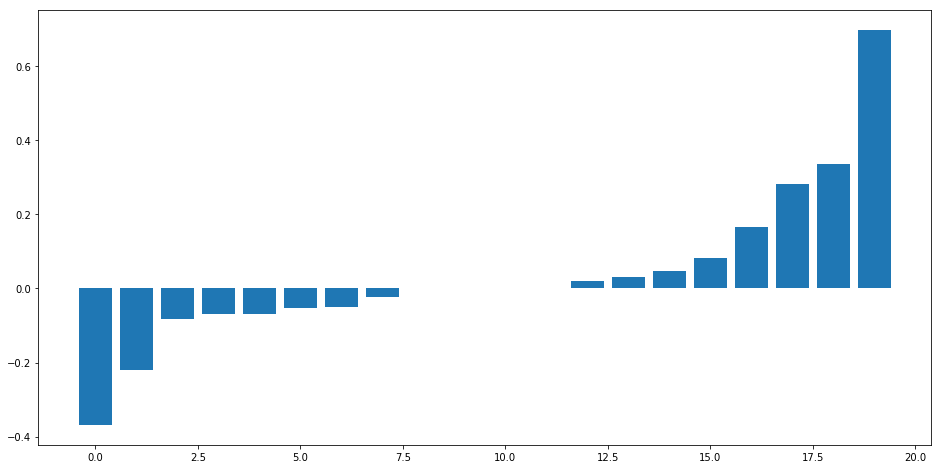

In [238]:
plt.figure(figsize=(16,8))
plt.bar([x for x in range(len(importance))], feature_importance.sort_values(by='importance').importance)

In [239]:
y_score_log_l1 = log_reg_l1.decision_function(x_test)
base_probs = [0 for _ in range(len(y_test))]
# len(base_probs), len(y_score_log_l1)

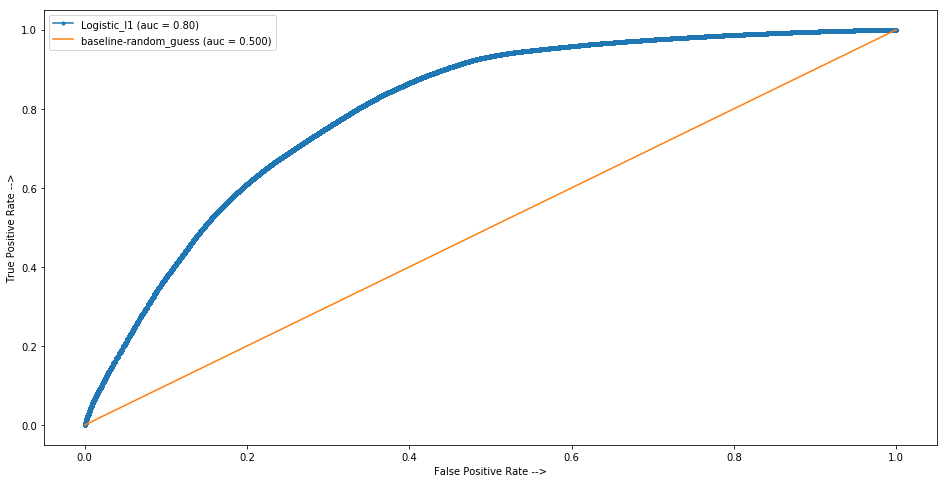

In [240]:
logistic_fpr, logistic_tpr, threshold = roc_curve(y_test, y_pred_prob_l1[:,1])
auc_logistic = auc(logistic_fpr, logistic_tpr)

base_fpr, base_tpr, base_threshold = roc_curve(y_test, base_probs)
auc_base = auc(base_fpr, base_tpr)

plt.figure(figsize=(16, 8))
plt.plot(logistic_fpr, logistic_tpr, marker='.', label='Logistic_l1 (auc = %0.2f)' % auc_logistic)
plt.plot(base_fpr, base_tpr, linestyle='-', label='baseline-random_guess (auc = %0.3f)' % auc_base)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()

plt.show()

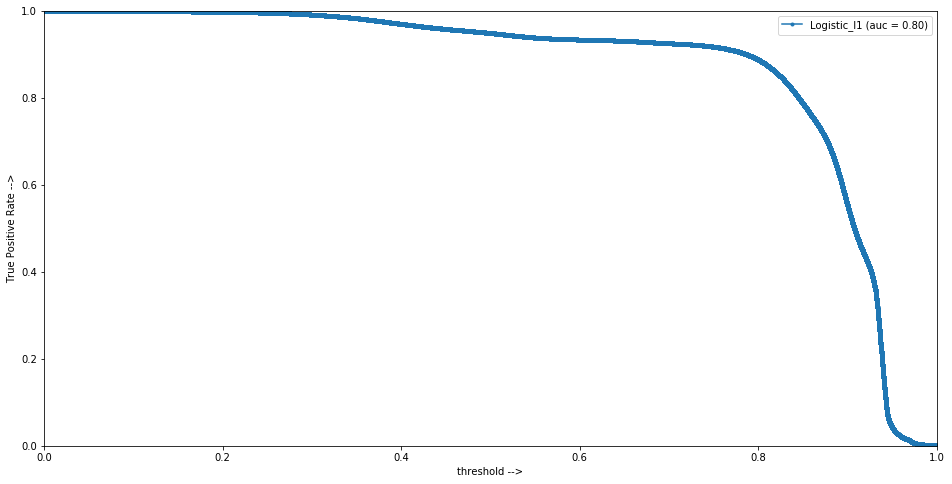

In [241]:
plt.figure(figsize=(16, 8))
plt.plot(threshold, logistic_tpr, marker='.', label='Logistic_l1 (auc = %0.2f)' % auc_logistic)
# plt.plot(base_fpr, base_tpr, linestyle='-', label='baseline-random_guess (auc = %0.3f)' % auc_base)

plt.xlabel('threshold -->')
plt.ylabel('True Positive Rate -->')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()

plt.show()

Text(0.5,1,'distribution of users profile - mix_ttd_avg')

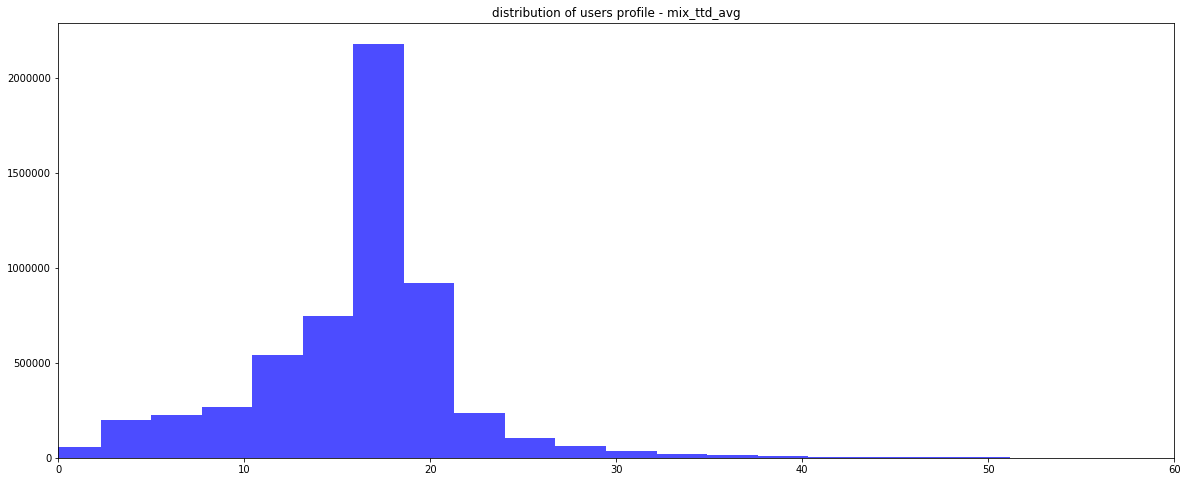

In [242]:
plt.figure(figsize=(20,8))
plt.xlim(0,60)
plt.hist(x=df6.mix_ttd_avg.dropna(axis='index'), bins=300, color='blue', alpha=0.7)
plt.title('distribution of users profile - mix_ttd_avg')

## drop high correlated features from original model

### max_shipping_time_shown_avg & we_order_p -55%
### late_days_avg(removed) & late_order_p 52% 
### refund_order_p(removed) & lr_order_p 53% 
### user_first_txn_refund_category & refund_order_p(removed) -74% & 64% 
### lr_order_p & user_first_txn_refund_category_logistics(removed) 69% 


In [286]:
df6.drop(['m_is_churned','gender','age','min_shipping_time_shown_avg','user_first_txn_refund_category','user_ltv_segment','user_first_txn_refund_cat','user_ltv_segment_cat','gmv'
                   ,'we_bucket','max_shown_bucket','bucket_ttd_avg','ttd_bucket','ttd_bucket_5-10','ttd_bucket_5-','ttd_bucket_10-15', 'ttd_bucket_15-20','ttd_bucket_20-25'
                   ,'ttd_bucket_25-30','ttd_bucket_30-40','ttd_bucket_40+'],axis=1).corr()

,waiting_day_1st_txn_bucket,order_cnt,max_shipping_time_shown_avg,mix_ttd_avg,gmv_avg,previous_m_is_churned,late_days_avg,late_order_p,refund_order_p,lr_order_p,we_order_p,gender_0,gender_1,gender_2,user_first_txn_refund_category_logistics refund,user_first_txn_refund_category_no refund,user_first_txn_refund_category_other refund,user_ltv_segment_ltv_high,user_ltv_segment_ltv_low,user_ltv_segment_ltv_med
waiting_day_1st_txn_bucket,1.000000,0.006586,-0.062075,-0.005561,0.029337,-0.025971,0.017653,0.025627,0.002673,0.005187,0.030227,-0.021999,-0.025083,0.031247,0.025105,-0.032244,0.020159,0.043547,-0.102544,0.057730
order_cnt,0.006586,1.000000,-0.002855,0.052181,-0.033621,-0.324962,0.178240,0.035828,-0.002555,-0.012514,-0.023908,-0.019236,-0.055184,0.060346,0.025199,-0.034813,0.023386,0.348325,-0.222607,-0.134489
max_shipping_time_shown_avg,-0.062075,-0.002855,1.000000,0.366544,-0.250399,0.069775,-0.087471,-0.193704,-0.030164,0.027201,-0.549583,-0.009598,-0.061323,0.063667,0.023356,0.018264,-0.043374,-0.134312,0.202079,-0.064121
mix_ttd_avg,-0.005561,0.052181,0.366544,1.000000,-0.167903,-0.037908,0.277589,0.238330,0.004004,0.043009,-0.402569,-0.005716,-0.063358,0.064570,0.048582,-0.019661,-0.016004,-0.047431,0.103617,-0.054825
gmv_avg,0.029337,-0.033621,-0.250399,-0.167903,1.000000,0.023354,0.014137,0.062231,0.126340,-0.009267,0.226454,0.030731,0.092247,-0.100466,-0.013012,-0.086562,0.122499,0.249399,-0.275150,0.019207
previous_m_is_churned,-0.025971,-0.324962,0.069775,-0.037908,0.023354,1.000000,-0.156625,-0.023580,0.017284,-0.018027,0.009924,0.027112,0.002868,-0.010657,-0.064641,0.032847,0.012688,-0.358116,0.252357,0.114830
late_days_avg,0.017653,0.178240,-0.087471,0.277589,0.014137,-0.156625,1.000000,0.463546,0.009309,0.028030,0.008478,-0.009137,-0.007535,0.010115,0.051726,-0.039066,0.006301,0.208242,-0.152375,-0.061154
late_order_p,0.025627,0.035828,-0.193704,0.238330,0.062231,-0.023580,0.463546,1.000000,0.006078,0.014360,0.075480,0.002864,0.002681,-0.003488,0.019673,-0.016023,0.003897,0.088575,-0.118425,0.027479
refund_order_p,0.002673,-0.002555,-0.030164,0.004004,0.126340,0.017284,0.009309,0.006078,1.000000,0.560678,0.033095,0.048499,0.004822,-0.018756,0.419653,-0.762676,0.624927,0.037953,-0.030257,-0.008665
lr_order_p,0.005187,-0.012514,0.027201,0.043009,-0.009267,-0.018027,0.028030,0.014360,0.560678,1.000000,-0.026821,0.013639,0.003113,-0.007020,0.745015,-0.472935,-0.024759,-0.031203,0.040880,-0.008844


In [260]:
# df6.columns

In [292]:
df_ori = df6.drop(['m_is_churned','gender','age','min_shipping_time_shown_avg','user_first_txn_refund_category','user_ltv_segment','user_first_txn_refund_cat','user_ltv_segment_cat','gmv'
                   ,'we_bucket','max_shown_bucket','bucket_ttd_avg','ttd_bucket','ttd_bucket_5-10','ttd_bucket_5-','ttd_bucket_10-15', 'ttd_bucket_15-20','ttd_bucket_20-25'
                   ,'ttd_bucket_25-30','ttd_bucket_30-40','ttd_bucket_40+'],axis=1)
new_drop_feature = ['refund_order_p','late_days_avg','we_order_p']

df_new = df_ori.drop(new_drop_feature,axis=1)

y= df6.m_is_churned

scaler = StandardScaler()
scaler.fit(df_new) 
X_scaled = pd.DataFrame(scaler.transform(df_new),columns = df_new.columns)

x_train, x_test, y_train, y_test = train_test_split(X_scaled,y,random_state=66,test_size=0.3, stratify=y)
x_train.shape,x_test.shape

log_reg_l1 = LogisticRegression(C=0.01, penalty='l1',solver='liblinear')
log_reg_l1.fit(x_train, y_train)
# round(100*log_reg_l1.score(x_test,y_test),1)

LogisticRegression(C=0.01, penalty='l1', solver='liblinear')

In [293]:
y_pred_l1 = log_reg_l1.predict(x_test)
y_pred_prob_l1 = log_reg_l1.predict_proba(x_test)
y_pred_l1, y_pred_prob_l1

print(classification_report(y_test,y_pred_l1))

print(confusion_matrix(y_test,y_pred_l1))

              precision    recall  f1-score   support

           0       0.65      0.44      0.53    303851
           1       0.89      0.95      0.92   1389461

    accuracy                           0.86   1693312
   macro avg       0.77      0.70      0.72   1693312
weighted avg       0.84      0.86      0.85   1693312

[[ 135189  168662]
 [  71442 1318019]]


In [294]:
tn, fp, fn, tp = confusion_matrix(y_test,y_pred_l1).ravel()
tn, fp, fn, tp

recall=tp/(tp+fn)
print('recall is {}%'.format(round(100*recall,1)))

#所有预测为y=1(churn)中，有86.6%真的churn了
precision = tp/(tp+fp)
print('precision is {}%'.format(round(100*precision,1)))
# round(100*precision,1)

# overall accuracy, equal to above score() = 83%
accuracy= (tp+tn)/(tp+tn+fn+fp)
print('overall accuracy is {}%'.format(round(100*accuracy,1)))

importance = log_reg_l1.coef_[0]
name = x_train.columns
feature_importance = pd.DataFrame(importance,index=name,columns=['importance'])
feature_importance.sort_values(by='importance')

recall is 94.9%
precision is 88.7%
overall accuracy is 85.8%


,importance
order_cnt,-0.376544
user_ltv_segment_ltv_high,-0.225993
mix_ttd_avg,-0.077778
waiting_day_1st_txn_bucket,-0.071576
gender_1,-0.054551
user_first_txn_refund_category_logistics refund,-0.032585
user_first_txn_refund_category_no refund,0.000000
gender_2,0.000000
user_ltv_segment_ltv_med,0.000000
late_order_p,0.004950


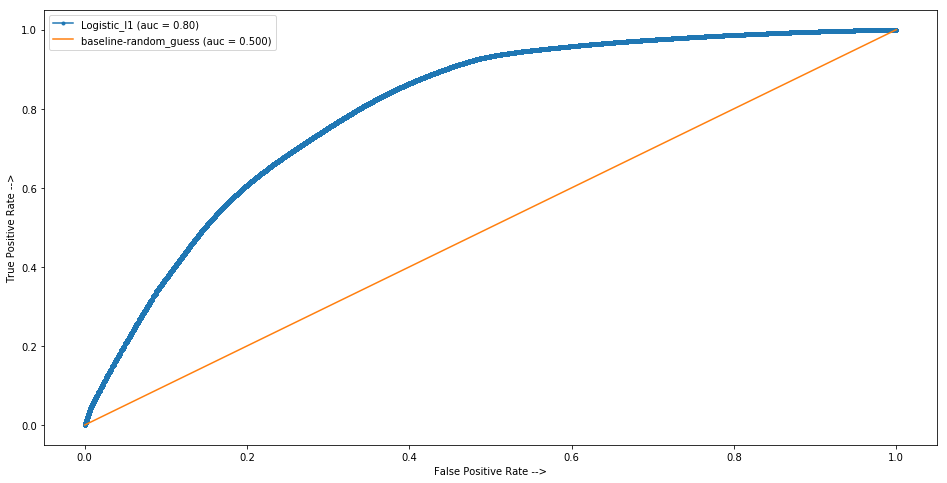

In [296]:
logistic_fpr, logistic_tpr, threshold = roc_curve(y_test, y_pred_prob_l1[:,1])
auc_logistic = auc(logistic_fpr, logistic_tpr)
# y_pred_prob_l1
base_probs = [0 for _ in range(len(y_test))]
base_fpr, base_tpr, base_threshold = roc_curve(y_test, base_probs)
auc_base = auc(base_fpr, base_tpr)

plt.figure(figsize=(16, 8))
plt.plot(logistic_fpr, logistic_tpr, marker='.', label='Logistic_l1 (auc = %0.2f)' % auc_logistic)
plt.plot(base_fpr, base_tpr, linestyle='-', label='baseline-random_guess (auc = %0.3f)' % auc_base)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()

plt.show()

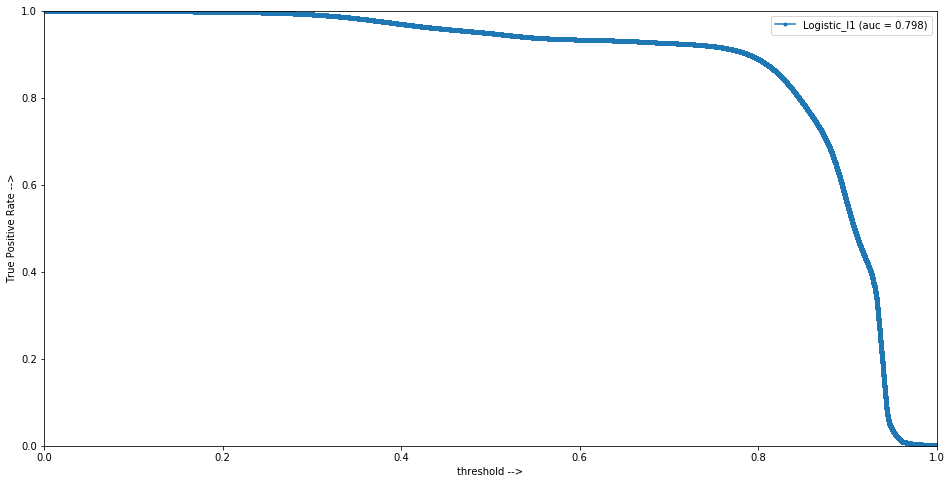

In [297]:
plt.figure(figsize=(16, 8))
plt.plot(threshold, logistic_tpr, marker='.', label='Logistic_l1 (auc = %0.3f)' % auc_logistic)
# plt.plot(base_fpr, base_tpr, linestyle='-', label='baseline-random_guess (auc = %0.3f)' % auc_base)

plt.xlabel('threshold -->')
plt.ylabel('True Positive Rate -->')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()

plt.show()

# applying a mask on ttd_avg

In [339]:
min = 8
max = 26
mask1 = df6.mix_ttd_avg >= min
mask2 = df6.mix_ttd_avg <= max

df_ori = df6[mask1 & mask2].drop(['m_is_churned','gender','age','min_shipping_time_shown_avg','user_first_txn_refund_category','user_ltv_segment','user_first_txn_refund_cat','user_ltv_segment_cat','gmv'
                   ,'we_bucket','max_shown_bucket','bucket_ttd_avg','ttd_bucket','ttd_bucket_5-10','ttd_bucket_5-','ttd_bucket_10-15', 'ttd_bucket_15-20','ttd_bucket_20-25'
                   ,'ttd_bucket_25-30','ttd_bucket_30-40','ttd_bucket_40+'],axis=1)
new_drop_feature = ['refund_order_p','late_days_avg','we_order_p']

df_new = df_ori.drop(new_drop_feature,axis=1)

y= df6[mask1 & mask2].m_is_churned

scaler = StandardScaler()
scaler.fit(df_new) 
X_scaled = pd.DataFrame(scaler.transform(df_new),columns = df_new.columns)

x_train, x_test, y_train, y_test = train_test_split(X_scaled,y,random_state=66,test_size=0.3, stratify=y)
x_train.shape,x_test.shape

log_reg_l1 = LogisticRegression(C=0.01, penalty='l1',solver='liblinear')
log_reg_l1.fit(x_train, y_train)
# round(100*log_reg_l1.score(x_test,y_test),1)
print('The average TTD from {} to {} days, covers {}% total orders'.format(min,max,round(
    100*sum((df6.mix_ttd_avg<=max) & (df6.mix_ttd_avg>=min))/len(df6.mix_ttd_avg),1)))

The average TTD from 8 to 26 days, covers 88.2% total orders


In [340]:
y_pred_l1 = log_reg_l1.predict(x_test)
y_pred_prob_l1 = log_reg_l1.predict_proba(x_test)
y_pred_l1, y_pred_prob_l1

print(classification_report(y_test,y_pred_l1))

print(confusion_matrix(y_test,y_pred_l1))

              precision    recall  f1-score   support

           0       0.66      0.47      0.55    273715
           1       0.89      0.95      0.92   1220589

    accuracy                           0.86   1494304
   macro avg       0.77      0.71      0.73   1494304
weighted avg       0.85      0.86      0.85   1494304

[[ 127494  146221]
 [  65410 1155179]]


In [341]:
tn, fp, fn, tp = confusion_matrix(y_test,y_pred_l1).ravel()
tn, fp, fn, tp

recall=tp/(tp+fn)
print('recall is {}%'.format(round(100*recall,1)))

#所有预测为y=1(churn)中，有86.6%真的churn了
precision = tp/(tp+fp)
print('precision is {}%'.format(round(100*precision,1)))
# round(100*precision,1)

# overall accuracy, equal to above score() = 83%
accuracy= (tp+tn)/(tp+tn+fn+fp)
print('overall accuracy is {}%'.format(round(100*accuracy,1)))

importance = log_reg_l1.coef_[0]
name = x_train.columns
feature_importance = pd.DataFrame(importance,index=name,columns=['importance'])
feature_importance.sort_values(by='importance')

recall is 94.6%
precision is 88.8%
overall accuracy is 85.8%


,importance
order_cnt,-0.333445
user_ltv_segment_ltv_high,-0.225643
waiting_day_1st_txn_bucket,-0.068650
gender_1,-0.046115
user_first_txn_refund_category_logistics refund,-0.031983
late_order_p,-0.010546
user_first_txn_refund_category_no refund,0.000000
user_ltv_segment_ltv_med,0.000000
mix_ttd_avg,0.000984
lr_order_p,0.003316


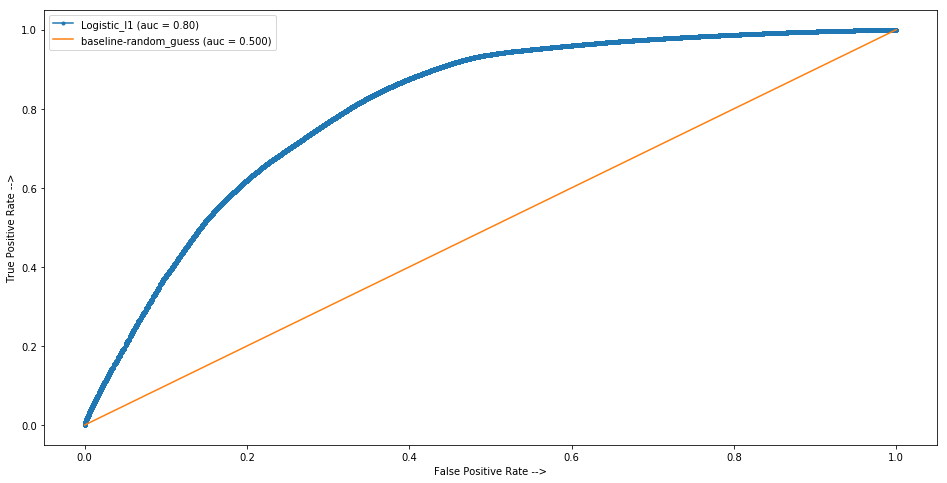

In [342]:
logistic_fpr, logistic_tpr, threshold = roc_curve(y_test, y_pred_prob_l1[:,1])
auc_logistic = auc(logistic_fpr, logistic_tpr)
# y_pred_prob_l1

base_probs = [0 for _ in range(len(y_test))]
base_fpr, base_tpr, base_threshold = roc_curve(y_test, base_probs)
auc_base = auc(base_fpr, base_tpr)

plt.figure(figsize=(16, 8))
plt.plot(logistic_fpr, logistic_tpr, marker='.', label='Logistic_l1 (auc = %0.2f)' % auc_logistic)
plt.plot(base_fpr, base_tpr, linestyle='-', label='baseline-random_guess (auc = %0.3f)' % auc_base)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()

plt.show()

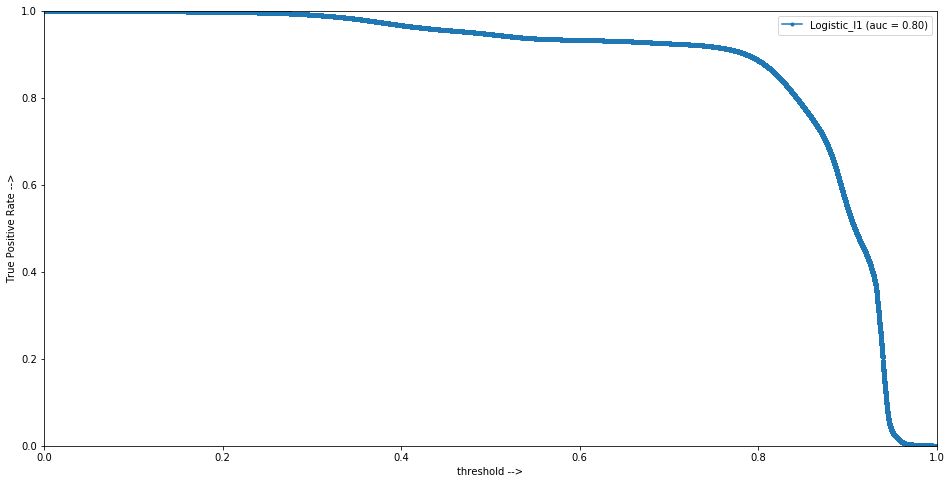

In [343]:
plt.figure(figsize=(16, 8))
plt.plot(threshold, logistic_tpr, marker='.', label='Logistic_l1 (auc = %0.2f)' % auc_logistic)
# plt.plot(base_fpr, base_tpr, linestyle='-', label='baseline-random_guess (auc = %0.3f)' % auc_base)

plt.xlabel('threshold -->')
plt.ylabel('True Positive Rate -->')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()

plt.show()

## try SMOTE metrod to over-sampling the imbalanced data

### split on original data

In [213]:
x_train.columns

Index(['waiting_day_1st_txn_bucket', 'order_cnt',
       'max_shipping_time_shown_avg', 'mix_ttd_avg', 'gmv_avg',
       'previous_m_is_churned', 'late_days_avg', 'late_order_p',
       'refund_order_p', 'lr_order_p', 'we_order_p', 'gender_0', 'gender_1',
       'gender_2', 'user_first_txn_refund_category_logistics refund',
       'user_first_txn_refund_category_no refund',
       'user_first_txn_refund_category_other refund',
       'user_ltv_segment_ltv_high', 'user_ltv_segment_ltv_low',
       'user_ltv_segment_ltv_med'],
      dtype='object')

In [36]:
# mask = df6.previous_m_is_churned== 1

X= df6.drop(['m_is_churned','gender','age','min_shipping_time_shown_avg','user_first_txn_refund_category','user_ltv_segment','user_first_txn_refund_cat'
             ,'user_ltv_segment_cat','gmv','we_bucket','max_shown_bucket','bucket_ttd_avg','ttd_bucket','ttd_bucket_10-15', 'ttd_bucket_15-20','ttd_bucket_20-25'
             , 'ttd_bucket_25-30', 'ttd_bucket_30-40','ttd_bucket_40+', 'ttd_bucket_5-', 'ttd_bucket_5-10'],axis=1)

scaler = StandardScaler()
scaler.fit(X) 

X_scaled = pd.DataFrame(scaler.transform(X),columns = X.columns)
y= df6.m_is_churned

x_train, x_test, y_train, y_test = train_test_split(X_scaled,y,random_state=66,test_size=0.3, stratify=y)
x_train.shape,x_test.shape

((3951060, 20), (1693312, 20))

In [37]:
print("normal data distribution: {}".format(Counter(y_train)))

normal data distribution: Counter({1: 3242074, 0: 708986})


Text(0.5,1,'churn tag=1 and tag=0 ratio is 4.5728321856849075:1 ')

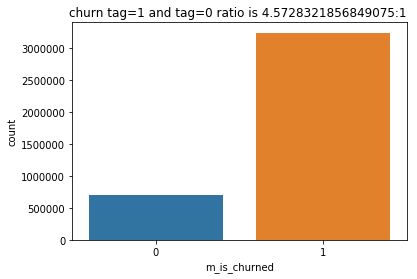

In [38]:
# data = df6
sns.countplot(y_train)
plt.title('churn tag=1 and tag=0 ratio is {}:1 '.format( sum(y_train==1)/sum(y_train==0)))

### SMOTE on training dataset only - 1:1 ratio

In [55]:
smote = SMOTE(sampling_strategy=0.3 ,random_state=12, k_neighbors=2)

In [56]:
X_smote, y_smote = smote.fit_sample(x_train, y_train)

Text(0.5,1,'churn tag=1 and tag=0 ratio is 3.333334018765769:1 ')

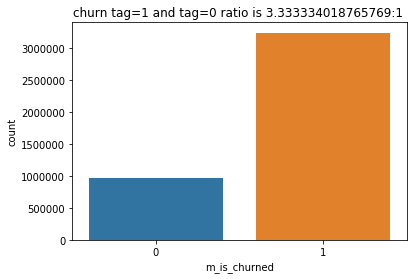

In [207]:
sns.countplot(y_smote)
plt.title('churn tag=1 and tag=0 ratio is {}:1 '.format( sum(y_smote==1)/sum(y_smote==0)))

In [208]:
log_reg_l1 = LogisticRegression(C=0.01, penalty='l1',solver='liblinear')
log_reg_l1.fit(X_smote, y_smote)
round(100*log_reg_l1.score(X_smote, y_smote),1)

83.3

In [209]:
y_pred_l1 = log_reg_l1.predict(x_test)
y_pred_prob_l1 = log_reg_l1.predict_proba(x_test)
y_pred_l1, y_pred_prob_l1

print(classification_report(y_test,y_pred_l1))

print(confusion_matrix(y_test,y_pred_l1))

              precision    recall  f1-score   support

           0       0.63      0.49      0.55    303851
           1       0.89      0.94      0.91   1389461

    accuracy                           0.86   1693312
   macro avg       0.76      0.71      0.73   1693312
weighted avg       0.85      0.86      0.85   1693312

[[ 149503  154348]
 [  89585 1299876]]


In [210]:
tn, fp, fn, tp = confusion_matrix(y_test,y_pred_l1).ravel()
tn, fp, fn, tp

recall=tp/(tp+fn)
print('model recall = {}'.format(round(100*recall,1)))

precision = tp/(tp+fp)
print('model precision = {}'.format(round(100*precision,1)))

accuracy= (tp+tn)/(tp+tn+fn+fp)
print('model accuracy = {}'.format(round(100*accuracy,1)))

importance = log_reg_l1.coef_[0]
name = x_train.columns
feature_importance = pd.DataFrame(importance,index=name,columns=['importance'])
feature_importance.sort_values(by='importance')

model recall = 93.6
model precision = 89.4
model accuracy = 85.6


,importance
order_cnt,-0.378917
user_ltv_segment_ltv_high,-0.217596
lr_order_p,-0.085741
waiting_day_1st_txn_bucket,-0.073684
mix_ttd_avg,-0.070564
gender_1,-0.054105
late_days_avg,-0.049773
user_first_txn_refund_category_logistics refund,-0.025837
gender_2,0.000000
user_first_txn_refund_category_other refund,0.000000


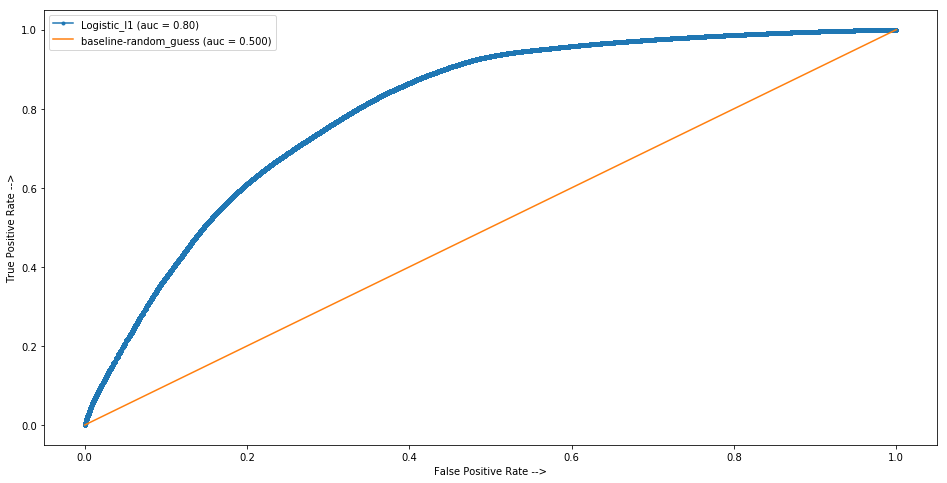

In [214]:
logistic_fpr, logistic_tpr, threshold = roc_curve(y_test, y_pred_prob_l1[:,1])
auc_logistic = auc(logistic_fpr, logistic_tpr)
# y_pred_prob_l1

base_probs = [0 for _ in range(len(y_test))]
base_fpr, base_tpr, base_threshold = roc_curve(y_test, base_probs)
auc_base = auc(base_fpr, base_tpr)

plt.figure(figsize=(16, 8))
plt.plot(logistic_fpr, logistic_tpr, marker='.', label='Logistic_l1 (auc = %0.2f)' % auc_logistic)
plt.plot(base_fpr, base_tpr, linestyle='-', label='baseline-random_guess (auc = %0.3f)' % auc_base)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()

plt.show()

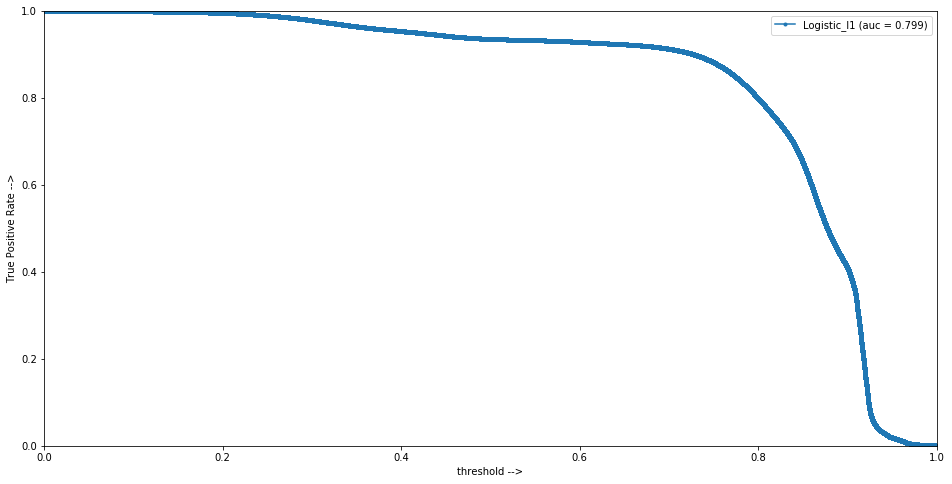

In [212]:
plt.figure(figsize=(16, 8))
plt.plot(threshold, logistic_tpr, marker='.', label='Logistic_l1 (auc = %0.3f)' % auc_logistic)
# plt.plot(base_fpr, base_tpr, linestyle='-', label='baseline-random_guess (auc = %0.3f)' % auc_base)

plt.xlabel('threshold -->')
plt.ylabel('True Positive Rate -->')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()

plt.show()